# Model Disagreement Analysis

This notebook analyzes the output CSVs from the inference pipeline.

In [25]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

csv_path = "../../outputs/imagenette_train.csv" # Example path

In [26]:
try:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples")
except FileNotFoundError:
    print("File not found. Run inference first.")

Loaded 1000 samples


Found 2 models: ['resnet18' 'mobilenet_v3_large']

ANALYSIS: resnet18
Accuracy: 0.9360
F1 (Weighted): 0.9669
Precision (Weighted): 1.0000
Recall (Weighted): 0.9360


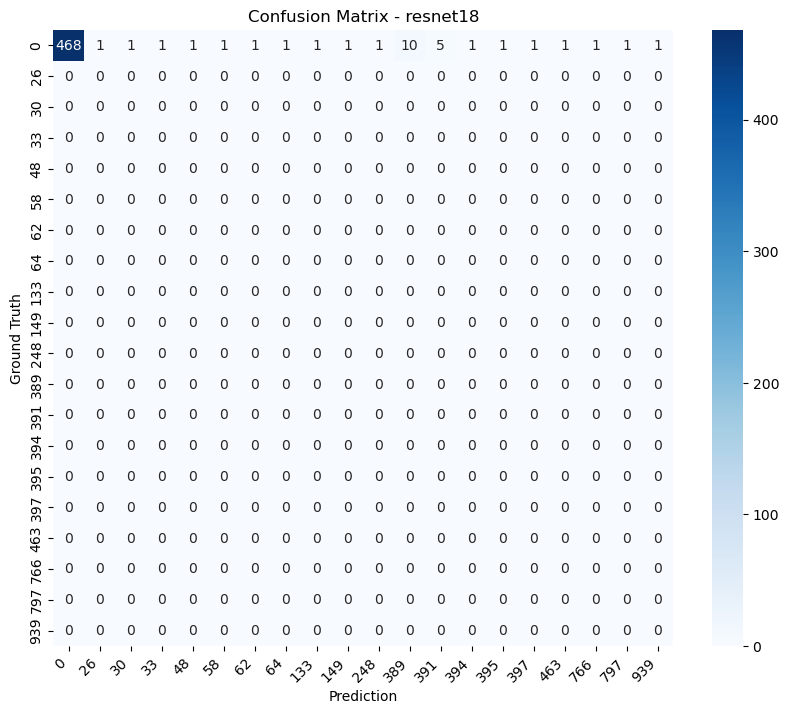


ANALYSIS: mobilenet_v3_large
Accuracy: 0.9400
F1 (Weighted): 0.9691
Precision (Weighted): 1.0000
Recall (Weighted): 0.9400


<Figure size 640x480 with 0 Axes>

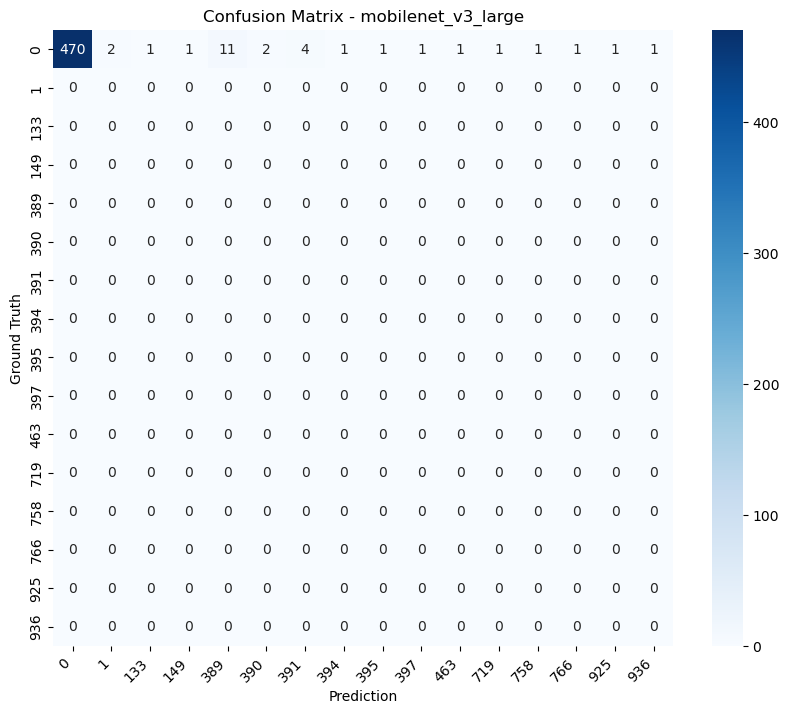

<Figure size 640x480 with 0 Axes>

In [27]:
if 'df' in locals():
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    model_ids = df['model_id'].unique()
    print(f"Found {len(model_ids)} models: {model_ids}")
    
    # Store metrics for comparison
    model_accuracies = {}
    
    # --- 1. Per-Model Analysis ---
    for mid in model_ids:
        print(f"\n{'='*20}")
        print(f"ANALYSIS: {mid}")
        print(f"{'='*20}")
        
        subset = df[df['model_id'] == mid]
        y_true = subset['ground_truth']
        y_pred = subset['prediction']
        
        # Calculate Metrics
        acc = accuracy_score(y_true, y_pred)
        model_accuracies[mid] = acc
        
        metrics = {
            "Accuracy": acc,
            "F1 (Weighted)": f1_score(y_true, y_pred, average='weighted', zero_division=0),
            "Precision (Weighted)": precision_score(y_true, y_pred, average='weighted', zero_division=0),
            "Recall (Weighted)": recall_score(y_true, y_pred, average='weighted', zero_division=0)
        }
        
        for name, val in metrics.items():
            print(f"{name}: {val:.4f}")
            
        # Confusion Matrix
        # Note: If many classes, this might be crowded. For ImageNet/Imagenette subset (10 classes), it works well.
        labels = sorted(list(set(y_true) | set(y_pred)))
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        plt.figure(figsize=(10, 8))
        # Plot only if reasonable size (e.g. <= 20 classes)
        if len(labels) <= 20: 
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.title(f"Confusion Matrix - {mid}")
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')
            plt.xticks(rotation=45, ha='right')
            plt.show()
        else:
            print(f"[INFO] Too many classes ({len(labels)}) for heatmap. Skipping display.")
        plt.tight_layout()



MODEL COMPARISON


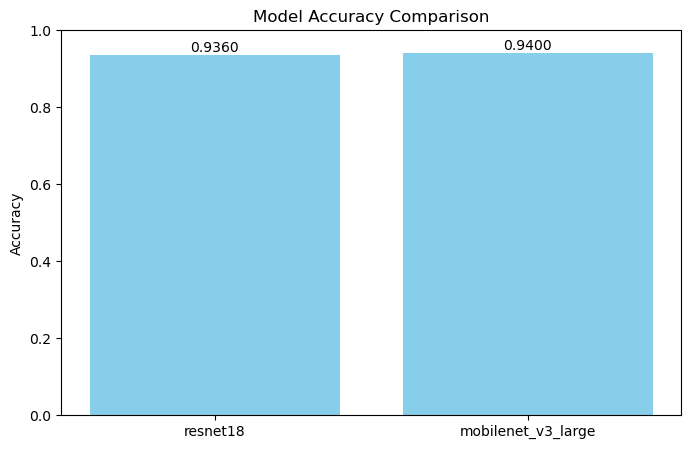


Comparing Agreement: resnet18 vs mobilenet_v3_large
Total Shared Samples: 500
Both Correct: 456
Only resnet18 Correct: 12
Only mobilenet_v3_large Correct: 14
Both Wrong: 18


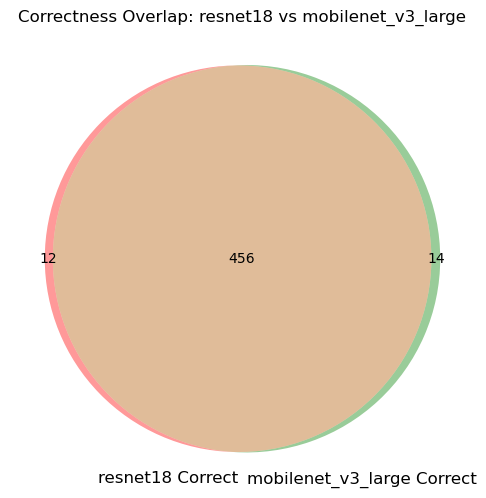

In [28]:
if 'df' in locals() and len(model_ids) > 1:
    print(f"\n{'='*20}")
    print("MODEL COMPARISON")
    print(f"{'='*20}")
    
    # Accuracy Bar Chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')
    plt.show()
    
    # Pairwise Agreement (Dynamic)
    # Compare first two distinct models if available
    if len(model_ids) >= 2:
        m1, m2 = model_ids[0], model_ids[1]
        print(f"\nComparing Agreement: {m1} vs {m2}")
        
        df1 = df[df['model_id'] == m1].copy()
        df2 = df[df['model_id'] == m2].copy()
        
        merged = pd.merge(df1, df2, on='sample_id', suffixes=('_1', '_2'))
        
        if not merged.empty:
            # Assuming ground truth is consistent
            gt = merged['ground_truth_1']
            
            c1 = merged['prediction_1'] == gt
            c2 = merged['prediction_2'] == gt
            
            both_correct = (c1 & c2).sum()
            only_m1 = (c1 & ~c2).sum()
            only_m2 = (~c1 & c2).sum()
            both_wrong = (~c1 & ~c2).sum()
            
            print(f"Total Shared Samples: {len(merged)}")
            print(f"Both Correct: {both_correct}")
            print(f"Only {m1} Correct: {only_m1}")
            print(f"Only {m2} Correct: {only_m2}")
            print(f"Both Wrong: {both_wrong}")
            
             # Venn Diagram
            try:
                from matplotlib_venn import venn2
                plt.figure(figsize=(6, 6))
                venn2(subsets=(only_m1, only_m2, both_correct), 
                      set_labels=(f'{m1} Correct', f'{m2} Correct'))
                plt.title(f"Correctness Overlap: {m1} vs {m2}")
                plt.show()
            except ImportError:
                print("[INFO] matplotlib-venn not installed. Skipping Venn plot.")
